In [30]:
import numpy as np
import os.path

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import layers
from tqdm import tqdm

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data_dir="mnist_data"
data = input_data.read_data_sets(data_dir, one_hot=True)

Extracting mnist_data/train-images-idx3-ubyte.gz
Extracting mnist_data/train-labels-idx1-ubyte.gz
Extracting mnist_data/t10k-images-idx3-ubyte.gz
Extracting mnist_data/t10k-labels-idx1-ubyte.gz


In [3]:
def leaky_relu(x, alpha=.2):
    with tf.name_scope("leaky_relu"):
        return tf.maximum(alpha*x, x)

In [4]:
DIM=64

In [5]:
def generator(z, mode="wgan", reuse=False):
    # noise is [batchsize X 128] in original paper
    with tf.variable_scope('generator', reuse=reuse):
        z = layers.fully_connected(z, num_outputs=DIM*4*4*4, activation_fn=tf.nn.relu)
        z = tf.reshape(z, [-1, 4, 4, 4*DIM]) # NHWC so channels in last layer

        z = layers.conv2d_transpose(z, num_outputs=2*DIM, kernel_size=5, 
                                    stride=2, activation_fn=tf.nn.relu)
        
        z = layers.conv2d_transpose(z, num_outputs=DIM, kernel_size=5, 
                                    stride=2, activation_fn=tf.nn.relu)
        
        z = layers.conv2d_transpose(z, num_outputs=1, kernel_size=5, 
                                    stride=2, activation_fn=tf.nn.sigmoid)
        z = z[:, 2:-2, 2:-2, :] # need to cut off for boundaries
        return z


In [6]:
def discriminator(x, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        x = layers.conv2d(x, num_outputs=DIM, kernel_size=5, stride=2,
                          activation_fn=leaky_relu)
        x = layers.conv2d(x, num_outputs=2*DIM, kernel_size=5, stride=2,
                          activation_fn=leaky_relu)
        x = layers.conv2d(x, num_outputs=4*DIM, kernel_size=5, stride=2,
                          activation_fn=leaky_relu)

        x = layers.flatten(x)
        return layers.fully_connected(x, num_outputs=1, activation_fn=None)


In [14]:
def build_graph(batchsize, seed=1234):
    with tf.name_scope('placeholders'):
        x_true = tf.placeholder(tf.float32, [batchsize, 28, 28, 1])
    
    z = tf.random_normal(shape=[batchsize, 128], seed=seed)
    x_generated = generator(z)
    y_true = discriminator(x_true, reuse=False)
    y_generated = discriminator(x_generated, reuse=True)

    with tf.name_scope('gradient-penalty'):
        alpha = tf.random_uniform([batchsize, 1], minval=0.0, maxval=1.0)
        differences = x_generated - x_true
        interpolates = x_true + alpha[:,None, None]*differences
        gradients = tf.gradients(discriminator(interpolates, reuse=True), [interpolates])[0]
        slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
        gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    with tf.name_scope('loss'):
        g_loss = tf.reduce_mean(y_generated)
        d_loss = (tf.reduce_mean(x_true) - tf.reduce_mean(x_generated)) + \
            10 * gradient_penalty

    return x_true, x_generated, g_loss, d_loss

tf.reset_default_graph()
x_true, x_generated, g_loss, d_loss = build_graph(50)

In [15]:
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)

    g_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator')
    g_train = optimizer.minimize(g_loss, var_list=g_vars)
    d_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator')
    d_train = optimizer.minimize(d_loss, var_list=d_vars)

In [28]:
npoints=len(data.train.images)
batchsize=50
batches= npoints//batchsize

1100


iter=0/20000


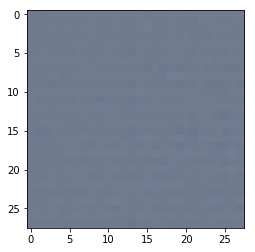

In [ ]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    print('iter={}/20000'.format(0))
    generated = x_generated.eval().squeeze()
    plt.figure('results')
    plt.imshow(generated[0], clim=[0, 1], cmap='bone')
    plt.show()
    for e in range(100):
        for i in range(batches):
            batch = data.train.next_batch(50)
            images = batch[0].reshape([-1, 28, 28, 1])

            sess.run(g_train)

            for j in range(5):
                sess.run(d_train, feed_dict={x_true: images})

        print('iter={}/{}'.format(e, batches))
        generated = x_generated.eval().squeeze()
        plt.figure('results')
        plt.imshow(generated[0], clim=[0, 1], cmap='bone')
        plt.show()